In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llama-2/pytorch/7b-chat-hf/1/model.safetensors.index.json
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/config.json
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/model-00001-of-00002.safetensors
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/model-00002-of-00002.safetensors
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/pytorch_model-00002-of-00002.bin
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/README.md
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/USE_POLICY.md
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/tokenizer.json
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/tokenizer_config.json
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/pytorch_model.bin.index.json
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/LICENSE.txt
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/pytorch_model-00001-of-00002.bin
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/special_tokens_map.json
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/.gitattributes
/kaggle/input/llama-2/pytorch/7b-chat-hf/1/tokenizer.model
/kaggle/input/llama-2/pyt

In [ ]:
import torch
from torch import cuda
import time
import pandas as pd
import numpy as np
import random

In [ ]:
!pip install -q -U bitsandbytes==0.42.0
!pip install -q -U peft==0.8.2
!pip install -q -U accelerate==0.27.1
!pip install -q -U transformers==4.38.0

In [ ]:
!pip install pyarrow==11.0.0

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import transformers

model_id = '/kaggle/input/llama-2/pytorch/7b-chat-hf/1'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Model loaded on {device}")

In [ ]:
!pip install -q -U trl

In [ ]:
from trl import SFTTrainer

# Dataset Loading & Preprocessing

In [ ]:
file_path_1 = "/kaggle/input/finance-bench-dataset/10_labels.csv"
file_path_2 = "/kaggle/input/finance-bench-dataset/syntheses_10.csv"
Model_Generated_Data = pd.read_csv(file_path_1)
Finance_data = pd.read_csv(file_path_2)
print(Finance_data.head())

In [ ]:
# Reduce Finance_data to the first 50 rows
Finance_Reduced_Test = Finance_data.head(50)
Finance_Reduced_Train = Finance_data.tail(100)
# Print the reduced DataFrame to verify
print(len(Finance_Reduced_Train))
print(len(Finance_Reduced_Test))

In [ ]:
Finance_Reduced_Train.drop('syntheses', axis=1, inplace=True)
Finance_Reduced_Train.columns

In [ ]:
Finance_Reduced_Train_Reduced_80 = Finance_Reduced_Train.head(80)
Validation_20 = Finance_Reduced_Train.tail(20)
len(Finance_Reduced_Train_Reduced_80)
len(Validation_20)

# Fine Tuning For 80 Training Data and 20 Validation Data

In [ ]:
import pandas as pd
from datasets import Dataset


prompts = []
for idx, row in Finance_Reduced_Train_Reduced_80.iterrows():
    question = row['question']
    answer = row['answer']
    evidence_text = row['evidence_text']  # Assuming you have access to this column

    SYSTEM_PROMPT = """You are a financial chatbot trained to answer questions based on the information provided.
Your responses should be directly sourced from the content of these evidence_text(context).
When asked a question, ensure that your answer is explicitly supported by the text and do not
include any external information, interpretations, or assumptions not clearly stated in the evidence_text(context).
If a question pertains to financial data or analysis that is not explicitly covered in the evidence_text(context) provided,
respond by stating that the information is not available in the evidence_text(context).
Your primary focus should be on accuracy, specificity, and adherence to the information in the evidence_text(context),
particularly regarding financial statements, company performance, and market positions."""

    prompt = f"<s>[INST]\n<<SYS>>\n{SYSTEM_PROMPT}\n<</SYS>>\n{question}\n{evidence_text}\n[/INST]\n{answer}\n</s>"
    prompts.append(prompt)

dataset = Dataset.from_pandas(pd.DataFrame({'text': prompts}))
dataset


In [ ]:
prompts = []
for idx, row in Validation_20.iterrows():
    question = row['question']
    answer = row['answer']
    evidence_text = row['evidence_text']  # Assuming you have access to this column

    SYSTEM_PROMPT = """You are a financial chatbot trained to answer questions based on the information provided.
Your responses should be directly sourced from the content of these evidence_text(context).
When asked a question, ensure that your answer is explicitly supported by the text and do not
include any external information, interpretations, or assumptions not clearly stated in the evidence_text(context).
If a question pertains to financial data or analysis that is not explicitly covered in the evidence_text(context) provided,
respond by stating that the information is not available in the evidence_text(context).
Your primary focus should be on accuracy, specificity, and adherence to the information in the evidence_text(context),
particularly regarding financial statements, company performance, and market positions."""

    prompt = f"<s>[INST]\n<<SYS>>\n{SYSTEM_PROMPT}\n<</SYS>>\n{question}\n{evidence_text}\n[/INST]\n{answer}\n</s>"
    prompts.append(prompt)

eval_dataset = Dataset.from_pandas(pd.DataFrame({'text': prompts}))
eval_dataset


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

print(model)

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=64,
    # target_modules=["query_key_value"],
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], #specific to Llama models.
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### For 5 Epoches

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    "Fine_Tuned_LLama2_5_Epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=2e-5,
    fp16=True,
    weight_decay=0.01,
    max_grad_norm=0.3,
    num_train_epochs=5,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    lr_scheduler_type="cosine",
    seed=42,
    push_to_hub=True,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=100,
    tokenizer=tokenizer,
    args=training_arguments,
)

Fine_tuned_LLama2_5_Epoch = trainer.train()


### For 10 Epoches

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    "Fine_Tuned_LLama2_10_Epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=2e-5,
    fp16=True,
    weight_decay=0.01,
    max_grad_norm=0.3,
    num_train_epochs=5,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    lr_scheduler_type="cosine",
    seed=42,
    push_to_hub=True,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=100,
    tokenizer=tokenizer,
    args=training_arguments,
)

Fine_tuned_80_10_Epoch = trainer.train()


### Fine Tuning for 15 Epoches

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    "Fine_Tuned_LLama2_15_Epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=2e-5,
    fp16=True,
    weight_decay=0.01,
    max_grad_norm=0.3,
    num_train_epochs=5,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    lr_scheduler_type="cosine",
    seed=42,
    push_to_hub=True,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=100,
    tokenizer=tokenizer,
    args=training_arguments,
)

Fine_tuned_80_15_Epoch = trainer.train()


# Prediction

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import transformers

model_id_1 = '/kaggle/working/Fine_Tuned_LLama2_5_Epoch'
model_id_2 = '/kaggle/working/Fine_Tuned_LLama2_10_Epoch'
model_id_3 = '/kaggle/working/Fine_Tuned_LLama2_15_Epoch'

#device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# fine_tuned_80_5_Epoch = AutoModelForCausalLM.from_pretrained(model_id_1, quantization_config=bnb_config, device_map="auto")
# tokenizer_1 = AutoTokenizer.from_pretrained(model_id_1)
# tokenizer_1.pad_token = tokenizer_1.eos_token
# tokenizer_1.padding_side = "right"

# fine_tuned_80_10_Epoch = AutoModelForCausalLM.from_pretrained(model_id_2, quantization_config=bnb_config, device_map="auto")
# tokenizer_2 = AutoTokenizer.from_pretrained(model_id_2)
# tokenizer_2.pad_token = tokenizer_2.eos_token
# tokenizer_2.padding_side = "right"

fine_tuned_80_15_Epoch = AutoModelForCausalLM.from_pretrained(model_id_3, quantization_config=bnb_config, device_map="auto")
tokenizer_3 = AutoTokenizer.from_pretrained(model_id_3)
tokenizer_3.pad_token = tokenizer_3.eos_token
tokenizer_3.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuratio

In [ ]:
# del fine_tuned_80_5_Epoch

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# import pandas as pd

# file_path_1 = "/kaggle/input/finance-bench-dataset/10_labels.csv"
# file_path_2 = "/kaggle/input/finance-bench-dataset/syntheses_10.csv"
# Model_Generated_Data = pd.read_csv(file_path_1)
# Finance_data = pd.read_csv(file_path_2)
# print(Finance_data.head())

In [ ]:
# # Reduce Finance_data to the first 50 rows
# Finance_Reduced_Validation = Finance_data.head(50)
# Finance_Reduced_Train = Finance_data.tail(100)
# # Print the reduced DataFrame to verify
# print(len(Finance_Reduced_Train))
# print(len(Finance_Reduced_Validation))

In [ ]:
import pandas as pd

file_path_2 = "/kaggle/input/finance-bench-dataset/syntheses_10.csv"
Finance_data = pd.read_csv(file_path_2)
print(Finance_data.head())

                                            question  \
0  What is the FY2018 capital expenditure amount ...   
1  Assume that you are a public equities analyst....   
2  Is 3M a capital-intensive business based on FY...   
3  What drove operating margin change as of FY202...   
4  If we exclude the impact of M&A, which segment...   

                                              answer  \
0                                           $1577.00   
1                                              $8.70   
2  No, the company is managing its CAPEX and Fixe...   
3  Operating Margin for 3M in FY2022 has decrease...   
4   The consumer segment shrunk by 0.9% organically.   

                                       evidence_text  \
0  Table of Contents \n3M Company and Subsidiarie...   
1  Table of Contents \n3M Company and Subsidiarie...   
2  3M Company and Subsidiaries\n Consolidated Sta...   
3  SG&A, measured as a percent of sales, increase...   
4  Worldwide Sales Change\nBy Business Segment

In [ ]:
Finance_data.drop('syntheses', axis=1, inplace=True)
Finance_data.columns

Index(['question', 'answer', 'evidence_text'], dtype='object')

In [ ]:
Finance_Reduced_Test= Finance_data.head(50)
len(Finance_Reduced_Test)

50

### For 5, 10 and 15 Epoch Models

In [ ]:
template ="""
<s>[INST] <<SYS>>
Give answer to questions provided below from the evidence text.
<</SYS>>

Here is the question:
{question}

Consider the provided text as evidence:
{evidence_text}
[/INST]

"""
count = 0
syntheses_with_llama = []

for idx, row in Finance_Reduced_Test.iterrows():
    question = row['question']
    evidence_text = row['evidence_text']

  # Construct prompt with context
    prompt = template.format(question=question, evidence_text=evidence_text)
    #print(prompt)

    # Tokenize the prompt
    inputs = tokenizer_3(prompt, return_tensors="pt")

    # Generate response
    output = fine_tuned_80_15_Epoch.generate(input_ids=inputs["input_ids"], max_new_tokens=100)

    # Decode the response
    generated_text = tokenizer_3.decode(output[0], skip_special_tokens=True)

    #Finding Extracted Answer
    answer_start = generated_text.find("[/INST]") + len("[/INST]")  # Find the end of </INST> tag
    answer = generated_text[answer_start:]  # Extract everything after that position
    syntheses_with_llama.append(answer)
    #print(answer)

    #Comparing the answer with the base answer
    dash_line = '-'.join('' for x in range(100))
    Answer = Finance_Reduced_Test.loc[idx, 'answer']
    #print(f'BASELINE HUMAN ANSWER:\n{Answer}\n')
    #print(dash_line)
    #print(f'MODEL GENERATION -  FINE_TUNED_15K:\n{answer}')
    #print(dash_line)
    print(count+1)
    count = count + 1
#Appending it to main file
Finance_Reduced_Test['Generated_BY_LLAMA2'] = syntheses_with_llama

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
2024-04-12 17:20:42.710412: E external/local_xla/xla/stream_exec

1


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


2
3
4
5
6
7
8
9


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/tmp/ipykernel_387/3223215126.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Finance_Reduced_Test['Generated_BY_LLAMA2'] = syntheses_with_llama


In [ ]:
from IPython.display import FileLink
fine_tuned_15_Epoch = Finance_Reduced_Test.rename(columns={'question': 'question', 'answer': 'answer', 'evidence_text': 'evidence_text', 'Generated_BY_LLAMA2': 'Generated_BY_LLAMA2'})
fine_tuned_15_Epoch.to_csv('fine_tuned_15_Epoch.csv', index=False)
FileLink('fine_tuned_15_Epoch.csv')

/kaggle/working/fine_tuned_15_Epoch.csv

In [ ]:
# torch.save(fine_tuned_80_15_Epoch.state_dict(), 'model.pth')

In [ ]:
# print("Hello")

Hello


# Evaluation

In [ ]:
import pandas as pd

file_path_10 = "/kaggle/input/fine-tuned-llama2-finance/fine_tuned_5_Epoch (1).csv"
file_path_11 = "/kaggle/input/fine-tuned-llama2-finance/fine_tuned_10_Epoch (1).csv"
file_path_12 = "/kaggle/input/fine-tuned-llama2-finance/fine_tuned_15_Epoch (1).csv"


Fine_Tuned_5 = pd.read_csv(file_path_10)
Fine_Tuned_10 = pd.read_csv(file_path_11)
Fine_Tuned_15 = pd.read_csv(file_path_12)

Fine_Tuned_15.head()

,question,answer,evidence_text,Generated_BY_LLAMA2
0,What is the FY2018 capital expenditure amount ...,$1577.00,Table of Contents \n3M Company and Subsidiarie...,\n\nBased on the information provided in the 3...
1,Assume that you are a public equities analyst....,$8.70,Table of Contents \n3M Company and Subsidiarie...,\n\nBased on the information provided in the b...
2,Is 3M a capital-intensive business based on FY...,"No, the company is managing its CAPEX and Fixe...",3M Company and Subsidiaries\n Consolidated Sta...,\n\nBased on the provided evidence from the 3M...
3,What drove operating margin change as of FY202...,Operating Margin for 3M in FY2022 has decrease...,"SG&A, measured as a percent of sales, increase...","\n\nBased on the provided text, the answer to ..."
4,"If we exclude the impact of M&A, which segment...",The consumer segment shrunk by 0.9% organically.,Worldwide Sales Change\nBy Business Segment Or...,\n\nBased on the evidence provided in the text...


In [ ]:
# # Assuming 'df' is your DataFrame containing the dataset
# # Replace 'df' with the actual name of your DataFrame

# # Selecting the 'answer' and 'Generated_BY_GEMMA' columns
# selected_columns = ['answer', 'Generated_BY_LLAMA2']

# # Printing the first 50 rows with a dash line between the columns
# for index, row in Fine_Tuned_5[selected_columns].head(50).iterrows():
#     print(f"{row['answer']} ------ {row['Generated_BY_LLAMA2']}")
#     print('--' * 50)  # Dash line separator

In [ ]:
from IPython.display import FileLink
Fine_Tuned_15.to_csv('fine_tuned_15_Epoch.csv', index=False)
FileLink('fine_tuned_15_Epoch.csv')

/kaggle/working/fine_tuned_15_Epoch.csv

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
def compute_rouge_l(candidate, reference):
    m, n = len(candidate), len(reference)
    #print(m,n)
    dp_table = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if candidate[i - 1] == reference[j - 1]:
                dp_table[i][j] = dp_table[i - 1][j - 1] + 1
            else:
                dp_table[i][j] = max(dp_table[i - 1][j], dp_table[i][j - 1])

    return dp_table[m][n] / n

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return filtered_tokens

In [ ]:
def compute_similarity_score(answer,syntheses):
    tokens_answer = preprocess_text(answer)
    tokens_syntheses = preprocess_text(syntheses)
    str_answer = ' '.join(tokens_answer)
    str_syntheses = ' '.join(tokens_syntheses)
    freqdist_answer = nltk.FreqDist(str_answer.split())
    freqdist_syntheses = nltk.FreqDist(str_syntheses.split())
    # Extract frequencies for unique tokens in both texts
    unique_tokens = set(freqdist_answer.keys()).union(freqdist_syntheses.keys())

    freq_answer = [freqdist_answer[token] for token in unique_tokens]
    freq_syntheses = [freqdist_syntheses[token] for token in unique_tokens]

    vector_answer = np.array(freq_answer).reshape(1, -1)
    vector_syntheses = np.array(freq_syntheses).reshape(1, -1)

    similarity_score = cosine_similarity(vector_answer, vector_syntheses)[0][0]

    return similarity_score

### For 5 Epoches

In [ ]:
import numpy as np

tfidf_vectorizer = TfidfVectorizer

total_average_rouge_l_scores_1 = []
total_average_cosine_similarity_scores_1  = []

num_labels_1 = []
count = 0

for i in range(5):
    count += 10
    num_labels_1.append(count)
    #print(num_labels)
    df = Fine_Tuned_5.head(count)
    #print(len(df))

    rouge_l_scores = []
    cosine_similarity_scores = []

    for idx, row in df.iterrows():
        answer = row['answer']
        syntheses = row['Generated_BY_LLAMA2']

        compute_sim_score = compute_similarity_score(answer,syntheses)
        cosine_similarity_scores.append(compute_sim_score)

        rouge_l_score = compute_rouge_l(answer, syntheses)
        rouge_l_scores.append(rouge_l_score)


    total_average_cosine_similarity_score = sum(cosine_similarity_scores) / len(cosine_similarity_scores)
    total_average_cosine_similarity_scores_1.append(total_average_cosine_similarity_score)


    total_average_rouge_l_score = sum(rouge_l_scores)/len(rouge_l_scores)
    total_average_rouge_l_scores_1.append(total_average_rouge_l_score)

    #print(total_average_cosine_similarity_scores_1)
    #print(total_average_rouge_l_scores_1)

[0.2358703270935707]
[0.18905374715804024]
[0.2358703270935707, 0.1827251369862751]
[0.18905374715804024, 0.12991284352378085]
[0.2358703270935707, 0.1827251369862751, 0.23152760804764907]
[0.18905374715804024, 0.12991284352378085, 0.16680985603845802]
[0.2358703270935707, 0.1827251369862751, 0.23152760804764907, 0.27036886005624466]
[0.18905374715804024, 0.12991284352378085, 0.16680985603845802, 0.18459994553607081]
[0.2358703270935707, 0.1827251369862751, 0.23152760804764907, 0.27036886005624466, 0.27273764937275496]
[0.18905374715804024, 0.12991284352378085, 0.16680985603845802, 0.18459994553607081, 0.16735522459073748]


### For 10 Epoches

In [ ]:
tfidf_vectorizer = TfidfVectorizer

total_average_rouge_l_scores_2 = []
total_average_cosine_similarity_scores_2  = []

num_labels_2 = []
count = 0

for i in range(5):
    count += 10
    num_labels_2.append(count)
    #print(num_labels)
    df = Fine_Tuned_10.head(count)
    #print(len(df))

    rouge_l_scores = []
    cosine_similarity_scores = []

    for idx, row in df.iterrows():
        answer = row['answer']
        syntheses = row['Generated_BY_LLAMA2']

        compute_sim_score = compute_similarity_score(answer,syntheses)
        cosine_similarity_scores.append(compute_sim_score)

        rouge_l_score = compute_rouge_l(answer, syntheses)
        rouge_l_scores.append(rouge_l_score)

    total_average_cosine_similarity_score = sum(cosine_similarity_scores) / len(cosine_similarity_scores)
    total_average_cosine_similarity_scores_2.append(total_average_cosine_similarity_score)

    total_average_rouge_l_score = sum(rouge_l_scores)/len(rouge_l_scores)
    total_average_rouge_l_scores_2.append(total_average_rouge_l_score)

    #print(total_average_cosine_similarity_scores_2)
    #print(total_average_rouge_l_scores_2)

### For 15 Epoches

In [ ]:
tfidf_vectorizer = TfidfVectorizer

total_average_rouge_l_scores_3 = []
total_average_cosine_similarity_scores_3  = []

num_labels_3 = []
count = 0

for i in range(5):
    count += 10
    num_labels_3.append(count)
    #print(num_labels)
    df = Fine_Tuned_15.head(count)
    #print(len(df))

    rouge_l_scores = []
    cosine_similarity_scores = []

    for idx, row in df.iterrows():
        answer = row['answer']
        syntheses = row['Generated_BY_LLAMA2']

        compute_sim_score = compute_similarity_score(answer,syntheses)
        cosine_similarity_scores.append(compute_sim_score)

        rouge_l_score = compute_rouge_l(answer, syntheses)
        rouge_l_scores.append(rouge_l_score)

    total_average_cosine_similarity_score = sum(cosine_similarity_scores) / len(cosine_similarity_scores)
    total_average_cosine_similarity_scores_3.append(total_average_cosine_similarity_score)

    total_average_rouge_l_score = sum(rouge_l_scores)/len(rouge_l_scores)
    total_average_rouge_l_scores_3.append(total_average_rouge_l_score)

    #print(total_average_cosine_similarity_scores_3)
    #print(total_average_rouge_l_scores_3)

### For 5 Epoch

Text(0.5, 1.0, ' After Fine-Tuning Cosine Similarity Score for 5 Epoch')

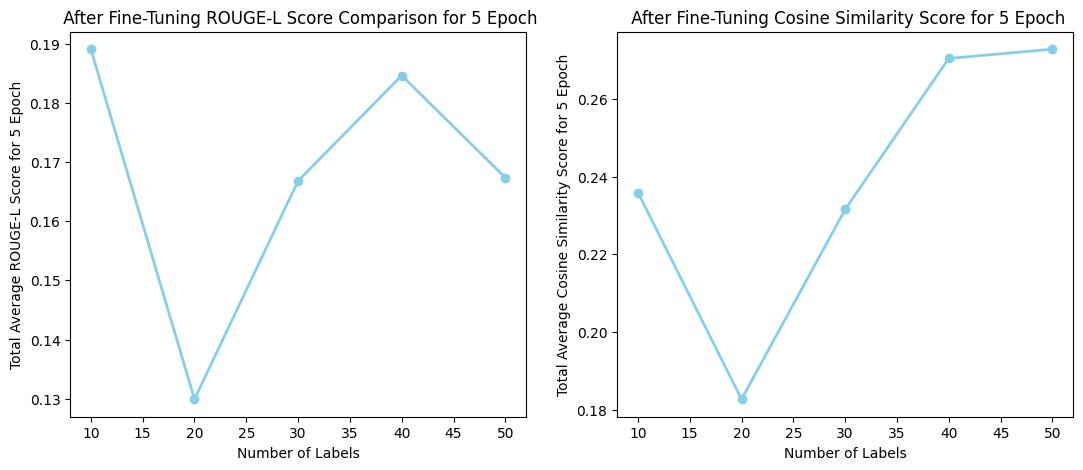

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

plt.figure(figsize=(20, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(num_labels_1, total_average_rouge_l_scores_1, marker='o', linestyle='-', color='skyblue', linewidth=2)

plt.xlabel('Number of Labels')
plt.ylabel('Total Average ROUGE-L Score for 5 Epoch')
plt.title(' After Fine-Tuning ROUGE-L Score Comparison for 5 Epoch')

plt.subplot(1, 3, 2)
plt.plot(num_labels_1, total_average_cosine_similarity_scores_1, marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Number of Labels')
plt.ylabel('Total Average Cosine Similarity Score for 5 Epoch')
plt.title(' After Fine-Tuning Cosine Similarity Score for 5 Epoch')

### For 10 Epoch

Text(0.5, 1.0, ' After Fine-Tuning Cosine Similarity Score for 10 Epoch')

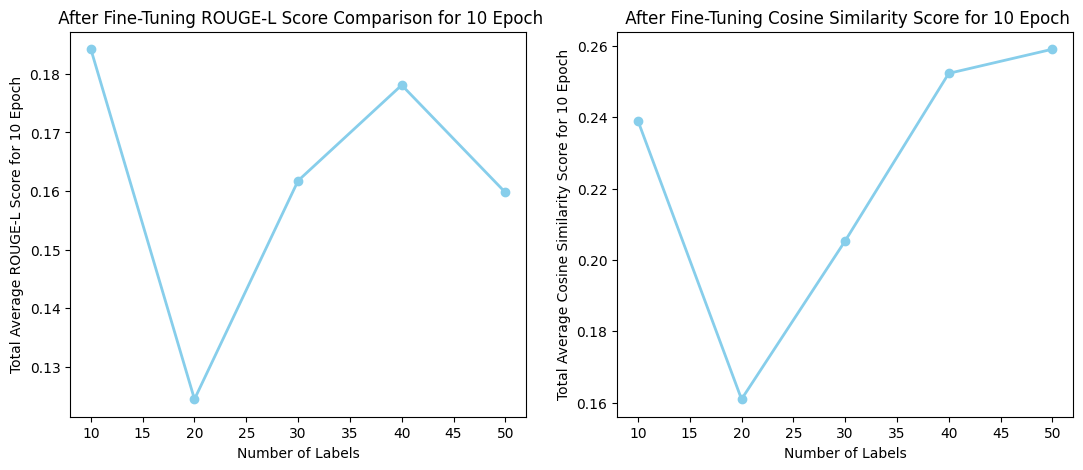

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

plt.figure(figsize=(20, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(num_labels_2, total_average_rouge_l_scores_2, marker='o', linestyle='-', color='skyblue', linewidth=2)

plt.xlabel('Number of Labels')
plt.ylabel('Total Average ROUGE-L Score for 10 Epoch')
plt.title(' After Fine-Tuning ROUGE-L Score Comparison for 10 Epoch')

plt.subplot(1, 3, 2)
plt.plot(num_labels_2, total_average_cosine_similarity_scores_2, marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Number of Labels')
plt.ylabel('Total Average Cosine Similarity Score for 10 Epoch')
plt.title(' After Fine-Tuning Cosine Similarity Score for 10 Epoch')

### For 15 Epoch

Text(0.5, 1.0, ' After Fine-Tuning Cosine Similarity Score for 15 Epoch')

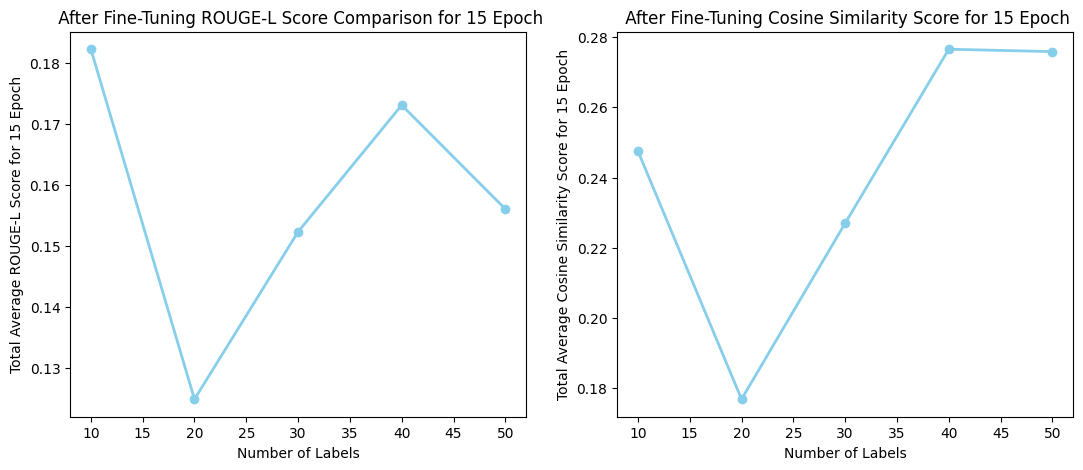

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

plt.figure(figsize=(20, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(num_labels_3, total_average_rouge_l_scores_3, marker='o', linestyle='-', color='skyblue', linewidth=2)

plt.xlabel('Number of Labels')
plt.ylabel('Total Average ROUGE-L Score for 15 Epoch')
plt.title(' After Fine-Tuning ROUGE-L Score Comparison for 15 Epoch')

plt.subplot(1, 3, 2)
plt.plot(num_labels_3, total_average_cosine_similarity_scores_3, marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Number of Labels')
plt.ylabel('Total Average Cosine Similarity Score for 15 Epoch')
plt.title(' After Fine-Tuning Cosine Similarity Score for 15 Epoch')

In [ ]:
# Fine_Tune_15_Cosine_Similarity = total_average_cosine_similarity_scores
# Fine_Tune_15_Rouge_L_Scores = total_average_rouge_l_scores

### Fine Tuning Finished